In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/UrbanSound8K"

/content/drive/MyDrive/UrbanSound8K


In [ ]:
NUM = 10 # Model number
epochs = 50
PATIENCE = 10
row_len = 513 # Number of columns: 1 + n_fft/2
col_len = 401 # Number of rows: 1 + (sampling_rate*audio_duration)/(0.01*sampling_rate); 0.01*sampling_rate = hop 
# audio_length = sampling_rate*audio_duration
# audio_duration = 4 seconds
BATCH_SIZE = 32

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import itertools
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow import config, distribute
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

In [ ]:
gpus = config.list_physical_devices('GPU');
print(gpus)

if len(gpus) == 1:
    strategy = distribute.OneDeviceStrategy(device="/gpu:0")
else:
    strategy = distribute.MirroredStrategy()

config.optimizer.set_experimental_options({"auto_mixed_precision": True})

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
TRAINING_FILENAMES = tf.io.gfile.glob("train/train*.tfrec")
VALIDATION_FILENAMES = tf.io.gfile.glob("val/val*.tfrec")
TEST_FILENAMES = tf.io.gfile.glob("test/test*.tfrec")

In [ ]:
def decode_STFT(data):
    data = tf.io.decode_raw(data, tf.float32)
    data = tf.reshape(data, [row_len, col_len, 1])
    return data
def decode_target(data):
    data = tf.io.decode_raw(data, tf.float32)
    data = tf.reshape(data, [10, ])
    return data

In [ ]:
def read_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "STFT": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    STFT = decode_STFT(example["STFT"])
    target = decode_target(example["target"])
    return STFT, target

In [ ]:
def load_dataset(filenames, ordered = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTO)
    return dataset

In [ ]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered = True):
    dataset = load_dataset(VALIDATION_FILENAMES, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered = True):
    dataset = load_dataset(TEST_FILENAMES, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [ ]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 3560 training images, 836 validation images, 836 unlabeled test images


In [ ]:
# training_dataset = get_training_dataset()
# training_dataset = training_dataset.unbatch().batch(20)
# train_batch = iter(training_dataset)
# stft, t = next(train_batch)

# print(stft.shape, t.shape)

(20, 513, 401, 1) (20, 10)


In [ ]:
from scipy.ndimage.filters import gaussian_filter1d

In [ ]:
def plot_metrics(history):
    metrics =  ['loss', 'accuracy']
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    figure, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

    for i, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        ysmoothed = gaussian_filter1d(history.history[metric], sigma = 2)
        # axes[i].plot(history.epoch, history.history[metric], color = colors[0], label = 'Train')
        axes[i].plot(history.epoch[:36], ysmoothed[:36], color = colors[0], label = 'Train')
        ysmoothed = gaussian_filter1d(history.history['val_' + metric], sigma = 2)
        # axes[i].plot(history.epoch, history.history['val_' + metric], color = colors[0], linestyle = "--", label = 'Val')
        axes[i].plot(history.epoch[:36], ysmoothed[:36], color = colors[0], linestyle = "--", label = 'Val')
        axes[i].axvline(x = index, color = "k", linestyle = "--")
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(name)
        axes[i].legend()
    figure.savefig("final_plot.png", quality = 100)

def plot_confusion_matrix(cm, target_names, title = 'Confusion matrix on Train Data', normalize = True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    cmap = plt.get_cmap('Blues')

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max()/1.5 if normalize else cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment = "center", color = "white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment = "center", color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy = {:0.4f}; misclass = {:0.4f}'.format(accuracy, misclass))
    plt.show()

def build_model():
    model = Sequential()
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size = 7, strides = 2, activation = 'relu', input_shape = (row_len, col_len, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = 4))
    model.add(Conv2D(64, kernel_size = 5, strides = 2, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = 4))
    model.add(Conv2D(128, kernel_size = 3, strides = 2, activation = 'relu'))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(n_classes, activation = 'softmax'))

    model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
    
    return model

In [ ]:
train = pd.read_csv("UrbanSound8K_train.csv")

LABELS = list(train["class"].unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train["label_idx"] = train["class"].apply(lambda x : label_idx[x])
n_classes = len(train["class"].unique())

classweight = class_weight.compute_class_weight("balanced", LABELS, train["class"])

In [ ]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

In [ ]:
cw = {}
for i in range(10):
    cw[i] = classweight[i]

In [ ]:
with strategy.scope():
    model = build_model()

checkpoint = ModelCheckpoint('models/best_%d.h5'%NUM, monitor = 'val_accuracy',  mode = 'max', verbose = 0, save_best_only = True)
early = EarlyStopping(monitor = "val_accuracy", mode = "max", patience = PATIENCE, verbose = 0)
annealer = LearningRateScheduler(lambda x : 1e-3*(0.95**x))
# callbacks_list = [checkpoint, early, annealer]
callbacks_list = [checkpoint, annealer]

history = model.fit(get_training_dataset(),
                    epochs = epochs,
                    validation_data = get_validation_dataset(ordered = True),
                    steps_per_epoch = STEPS_PER_EPOCH,
                    class_weight = cw,
                    callbacks = callbacks_list)

Epoch 1/50
111/111 [==============================] - 69s 306ms/step - loss: 1.5248 - accuracy: 0.3714 - val_loss: 2.4129 - val_accuracy: 0.0000e+00
Epoch 2/50
111/111 [==============================] - 80s 728ms/step - loss: 2.2378 - accuracy: 0.2148 - val_loss: 2.4433 - val_accuracy: 0.0108
Epoch 3/50
111/111 [==============================] - 67s 606ms/step - loss: 2.1552 - accuracy: 0.2927 - val_loss: 2.3376 - val_accuracy: 0.0383
Epoch 4/50
111/111 [==============================] - 43s 390ms/step - loss: 2.1286 - accuracy: 0.3119 - val_loss: 2.2926 - val_accuracy: 0.1208
Epoch 5/50
111/111 [==============================] - 23s 205ms/step - loss: 1.9153 - accuracy: 0.2963 - val_loss: 3.3743 - val_accuracy: 0.0897
Epoch 6/50
111/111 [==============================] - 14s 122ms/step - loss: 1.8344 - accuracy: 0.3142 - val_loss: 1.8112 - val_accuracy: 0.3947
Epoch 7/50
111/111 [==============================] - 11s 99ms/step - loss: 1.9413 - accuracy: 0.2664 - val_loss: 1.7547 - val

Maximum Validation accuracy = 64.833, Corresponding Training accuracy = 36.064


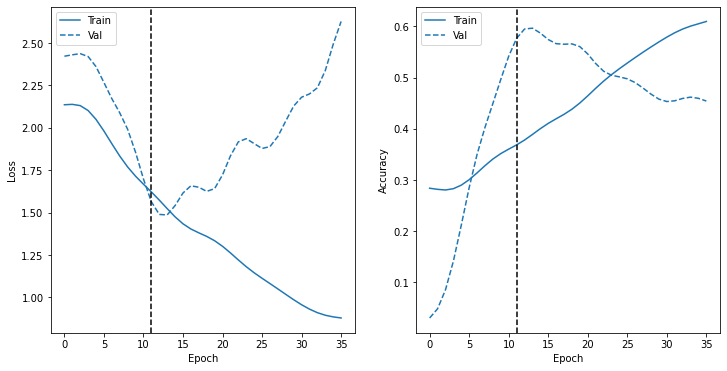

In [ ]:
index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
plot_metrics(history)
print("Maximum Validation accuracy = {1:.3f}, Corresponding Training accuracy = {0:.3f}".format(100*history.history['accuracy'][index], 100*history.history['val_accuracy'][index]))

In [ ]:
model.load_weights("models/best_10.h5")

In [ ]:
predictions = model.evaluate(get_test_dataset(ordered = True), batch_size = BATCH_SIZE)
# predictions = np.array(LABELS)[np.argmax(predictions, axis = 1)]
# CM = confusion_matrix(train["class"], predictions)
# plot_confusion_matrix(CM, train["class"].unique())
print(predictions)

27/27 [==============================] - 5s 94ms/step - loss: 1.4612 - accuracy: 0.6029
[1.4612184762954712, 0.6028708219528198]


In [ ]:
preds = []
for i in range(836):
    preds.append(model.predict(np.expand_dims(np.load("test_np/STFT%d.npy"%i), axis = 0)))

In [ ]:
predictions = np.array(LABELS)[np.argmax(np.array(preds), axis = 2)]